In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose  
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Prep

In [21]:
import pandas as pd

# Load the primary dataset
df1 = pd.read_csv('UNRATE.csv', parse_dates=['DATE'], index_col='DATE')

# Load other datasets
dfs = {
    'BBKMGDP': pd.read_csv('BBKMGDP.csv', parse_dates=['DATE'], index_col='DATE'),
    'BUSLOANSNSA': pd.read_csv('BUSLOANSNSA.csv', parse_dates=['DATE'], index_col='DATE'),
    'CPALTT01USM657N': pd.read_csv('CPALTT01USM657N.csv', parse_dates=['DATE'], index_col='DATE'),
    'FEDFUNDS': pd.read_csv('FEDFUNDS.csv', parse_dates=['DATE'], index_col='DATE'),
    'M2NS': pd.read_csv('M2NS.csv', parse_dates=['DATE'], index_col='DATE'),
    'PPIACO': pd.read_csv('PPIACO.csv', parse_dates=['DATE'], index_col='DATE'),
    'REALLNNSA': pd.read_csv('REALLNNSA.csv', parse_dates=['DATE'], index_col='DATE')
}

# Perform a left join for each dataframe to df1 (UNRATE)
for key, df in dfs.items():
    df1 = pd.merge(df1, df, on='DATE', how='left')

In [22]:
df1.head()

,UNRATE,BBKMGDP,BUSLOANSNSA,CPALTT01USM657N,FEDFUNDS,M2NS,PPIACO,REALLNNSA
DATE,,,,,,,,
1948-01-01,3.4,NaN,14.8445,NaN,NaN,NaN,27.7,8.8328
1948-02-01,3.8,NaN,14.8212,NaN,NaN,NaN,27.2,8.9624
1948-03-01,4.0,NaN,14.7971,NaN,NaN,NaN,27.2,9.0918
1948-04-01,3.9,NaN,14.7729,NaN,NaN,NaN,27.4,9.2256
1948-05-01,3.5,NaN,14.7487,NaN,NaN,NaN,27.5,9.3575


In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 919 entries, 1948-01-01 to 2024-07-01
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UNRATE           919 non-null    float64
 1   BBKMGDP          774 non-null    float64
 2   BUSLOANSNSA      919 non-null    float64
 3   CPALTT01USM657N  830 non-null    float64
 4   FEDFUNDS         841 non-null    float64
 5   M2NS             786 non-null    float64
 6   PPIACO           919 non-null    float64
 7   REALLNNSA        919 non-null    float64
dtypes: float64(8)
memory usage: 64.6 KB


In [24]:
# Filter the DataFrame to include only records from January 1, 1960, onwards
filtered_df = df1[(df1.index >= '1960-01-01') & (df1.index <='2024-03-01')]

In [25]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 771 entries, 1960-01-01 to 2024-03-01
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UNRATE           771 non-null    float64
 1   BBKMGDP          771 non-null    float64
 2   BUSLOANSNSA      771 non-null    float64
 3   CPALTT01USM657N  771 non-null    float64
 4   FEDFUNDS         771 non-null    float64
 5   M2NS             771 non-null    float64
 6   PPIACO           771 non-null    float64
 7   REALLNNSA        771 non-null    float64
dtypes: float64(8)
memory usage: 54.2 KB


In [30]:
filtered_df.reset_index(inplace=True)

In [31]:
filtered_df.head()

,DATE,UnemploymentRate,GDP,CommLoans,CPIGrowthRate,FedFunds,MoneySupply,ProducerPriceIndex,RELoans
0,1960-01-01,5.2,15.572097,39.5918,-0.340136,3.99,301.5,31.6,27.6453
1,1960-02-01,4.8,6.220612,39.3687,0.341297,3.97,298.5,31.6,27.5965
2,1960-03-01,5.4,-4.063160,40.1776,0.000000,3.84,298.2,31.8,27.6361
3,1960-04-01,5.2,-4.134117,40.6229,0.340136,3.92,300.3,31.8,27.6951
4,1960-05-01,5.1,-3.431832,40.8703,0.000000,3.85,298.9,31.7,27.7338


In [32]:
# Rename the columns based on the uploaded image (adjust according to actual names and your requirement)
filtered_df.rename(columns={
    'DATE': 'observation_date',
    'UNRATE': 'UnemploymentRate',
    'FEDFUNDS': 'FedFunds',
    'M2NS': 'MoneySupply',
    'PPIACO': 'ProducerPriceIndex',
    'CPALTT01USM657N': 'CPIGrowthRate',
    'BBKMGDP': 'GDP',
    'BUSLOANSNSA': 'CommLoans',
    'REALLNNSA': 'RELoans'
}, inplace=True)

# Optionally, calculate year, month, and quarter if you want them derived from the observation_date
filtered_df['year'] = filtered_df['observation_date'].dt.year
filtered_df['month'] = filtered_df['observation_date'].dt.month
filtered_df['quarter'] = filtered_df['observation_date'].dt.to_period('Q').dt.strftime('Q%q')

/var/folders/sf/twdrtcxd31b6rkjt8r5mdxr40000gn/T/ipykernel_28453/2365051608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={
/var/folders/sf/twdrtcxd31b6rkjt8r5mdxr40000gn/T/ipykernel_28453/2365051608.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year'] = filtered_df['observation_date'].dt.year
/var/folders/sf/twdrtcxd31b6rkjt8r5mdxr40000gn/T/ipykernel_28453/2365051608.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [33]:
filtered_df.head()

,observation_date,UnemploymentRate,GDP,CommLoans,CPIGrowthRate,FedFunds,MoneySupply,ProducerPriceIndex,RELoans,year,month,quarter
0,1960-01-01,5.2,15.572097,39.5918,-0.340136,3.99,301.5,31.6,27.6453,1960,1,Q1
1,1960-02-01,4.8,6.220612,39.3687,0.341297,3.97,298.5,31.6,27.5965,1960,2,Q1
2,1960-03-01,5.4,-4.063160,40.1776,0.000000,3.84,298.2,31.8,27.6361,1960,3,Q1
3,1960-04-01,5.2,-4.134117,40.6229,0.340136,3.92,300.3,31.8,27.6951,1960,4,Q2
4,1960-05-01,5.1,-3.431832,40.8703,0.000000,3.85,298.9,31.7,27.7338,1960,5,Q2


In [34]:
filtered_df.to_csv('unemp_final_data.csv')

# EDA

In [59]:
data = pd.read_csv('unemp_final_data.csv')

In [61]:
# Drop the first column based on index position
data = data.drop(data.columns[0], axis=1)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   observation_date    771 non-null    object 
 1   UnemploymentRate    771 non-null    float64
 2   GDP                 771 non-null    float64
 3   CommLoans           771 non-null    float64
 4   CPIGrowthRate       771 non-null    float64
 5   FedFunds            771 non-null    float64
 6   MoneySupply         771 non-null    float64
 7   ProducerPriceIndex  771 non-null    float64
 8   RELoans             771 non-null    float64
 9   year                771 non-null    int64  
 10  month               771 non-null    int64  
 11  quarter             771 non-null    object 
dtypes: float64(8), int64(2), object(2)
memory usage: 72.4+ KB


In [63]:
# Ensure the date column is in datetime format (if not already)
data['observation_date'] = pd.to_datetime(data['observation_date'])

<Axes: xlabel='month', ylabel='UnemploymentRate'>

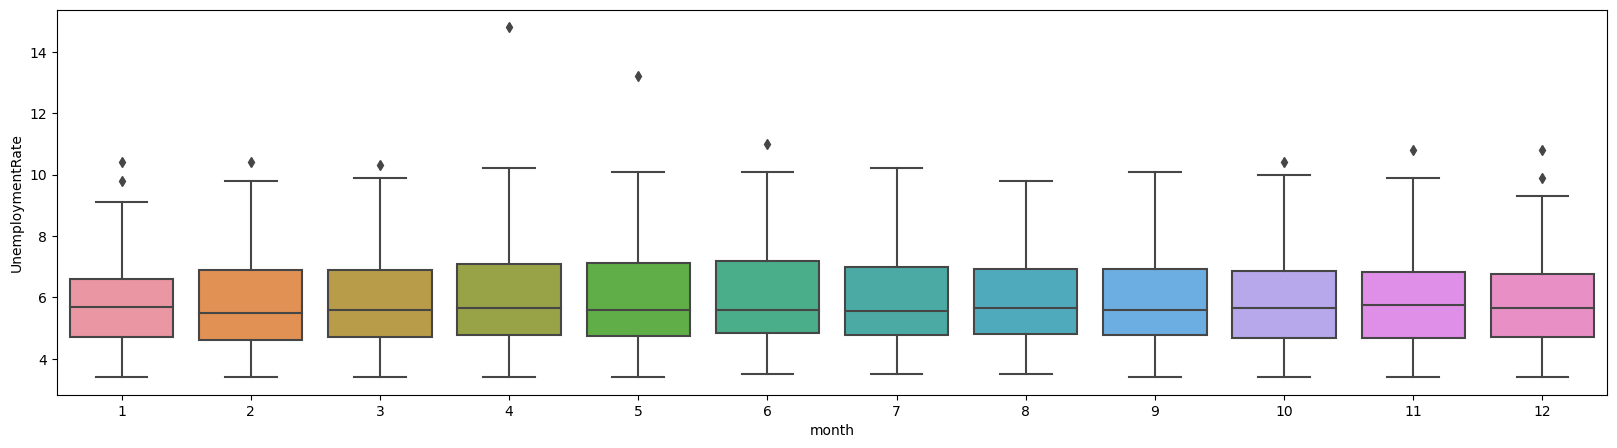

In [39]:
plt.subplots(figsize=(20,5))
sns.boxplot(x=data['month'],y=data['UnemploymentRate'])

<Axes: xlabel='quarter', ylabel='UnemploymentRate'>

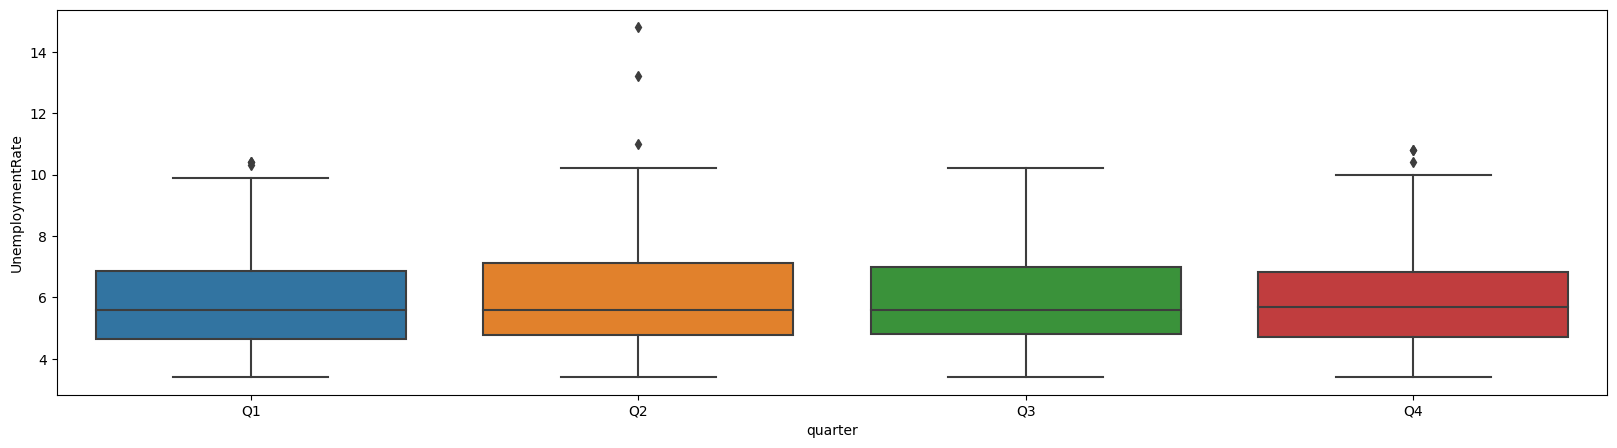

In [40]:
plt.subplots(figsize=(20,5))
sns.boxplot(x=data['quarter'],y=data['UnemploymentRate'])

nothing quite extraordinarily different across months or quarters.

### univar analysis

/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


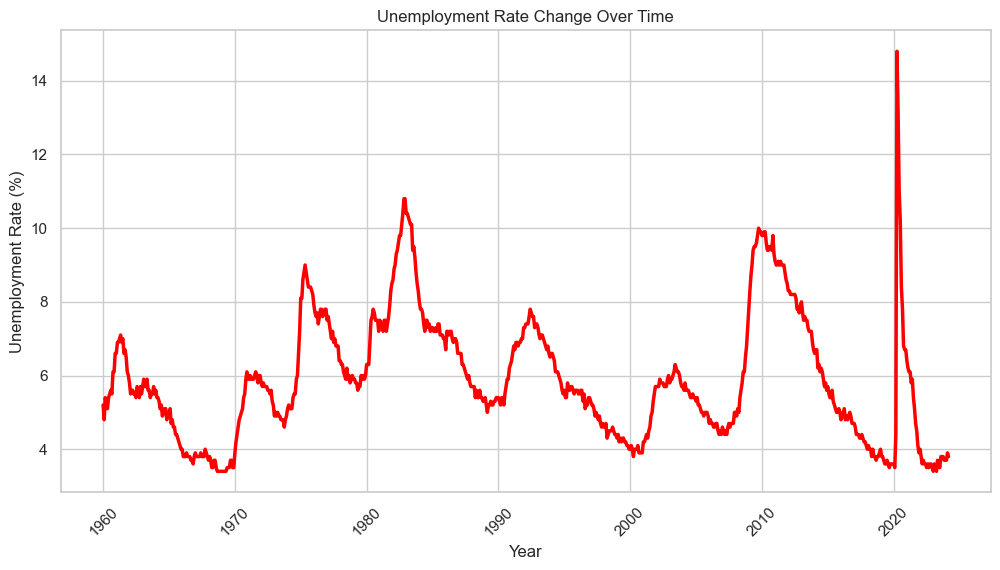

In [69]:
# Set the date column as the index of the DataFrame
#data.set_index('observation_date', inplace=True, drop= True)
# Creating the plot
plt.figure(figsize=(12, 6))  # Size of the plot
sns.set(style="whitegrid")  # Background grid for better readability

# Create line plot
ax = sns.lineplot(x='observation_date', y='UnemploymentRate', data=data, color='red', linewidth=2.5)

# Formatting the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(10))  # Major ticks every 10 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Only show the year

# More aesthetic customizations
plt.title('Unemployment Rate Change Over Time')  # Title
plt.xlabel('Year')  # X-axis Label
plt.ylabel('Unemployment Rate (%)')  # Y-axis Label
plt.xticks(rotation=45)  # Rotate dates for better readability

# Show the plot
plt.show()

Figure shows the unemployment rate is stationary (constant mean) with varying volatility over the range of period shown here.

/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


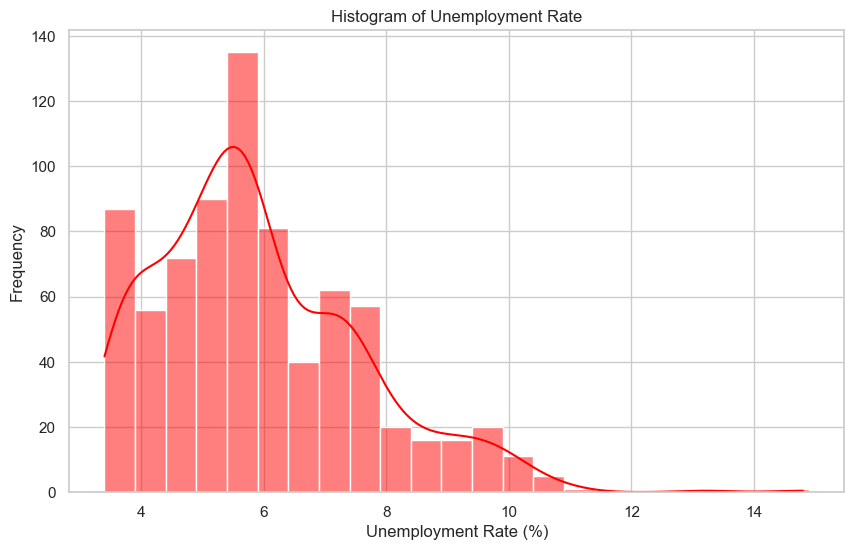

In [70]:
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.histplot(data['UnemploymentRate'], kde=True, color='red', binwidth=0.5)  # KDE plots a curve of the distribution's density

# Add titles and labels
plt.title('Histogram of Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

Distribution of unemployment rate for this period, it ranges from 3.5% to over 10.5% with the distribution skewed to the right. This data doesn’t quite have a normal distribution.

In [71]:
data_diff = data.copy()

/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

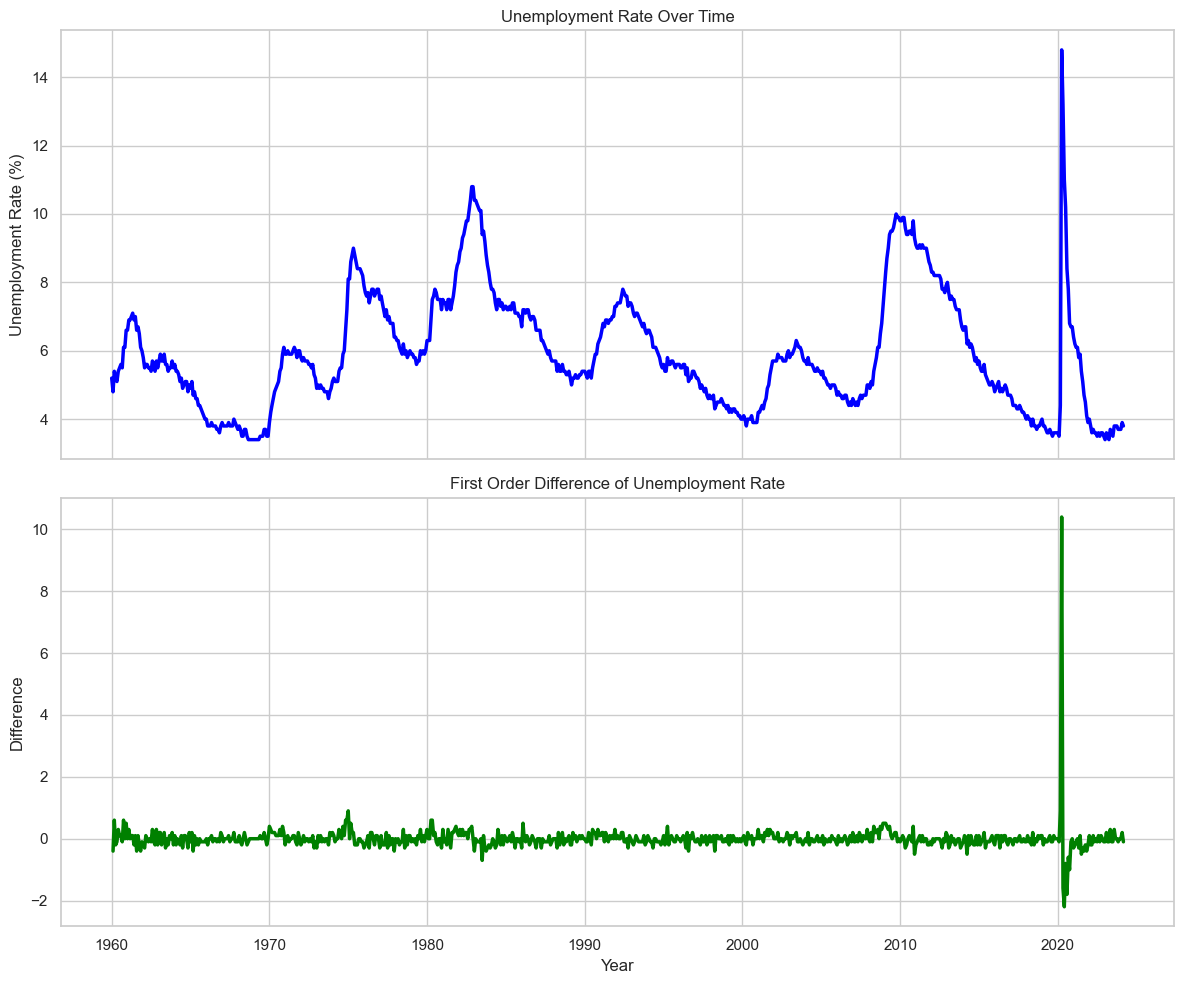

In [78]:
#data_diff.set_index('observation_date', inplace=True)

# Calculate the first-order difference of the unemployment rate
data_diff['unemp rate diff'] = data_diff['UnemploymentRate'].diff()

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with two subplots (rows)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot Unemployment Rate
sns.lineplot(ax=axes[0], x=data_diff.index, y=data_diff['UnemploymentRate'], color='blue', linewidth=2.5)
axes[0].set_title('Unemployment Rate Over Time')
axes[0].set_ylabel('Unemployment Rate (%)')

# Plot First-Order Difference of Unemployment Rate
sns.lineplot(ax=axes[1], x=data_diff.index, y=data_diff['unemp rate diff'], color='green', linewidth=2.5)
axes[1].set_title('First Order Difference of Unemployment Rate')
axes[1].set_ylabel('Difference')
axes[1].set_xlabel('Year')

# Show the plot
plt.tight_layout()
plt.show()

comparative view of the unemployment rate and its first order difference (1D) computed by calculating the difference in consecutive values of the unemployment rate data).

/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


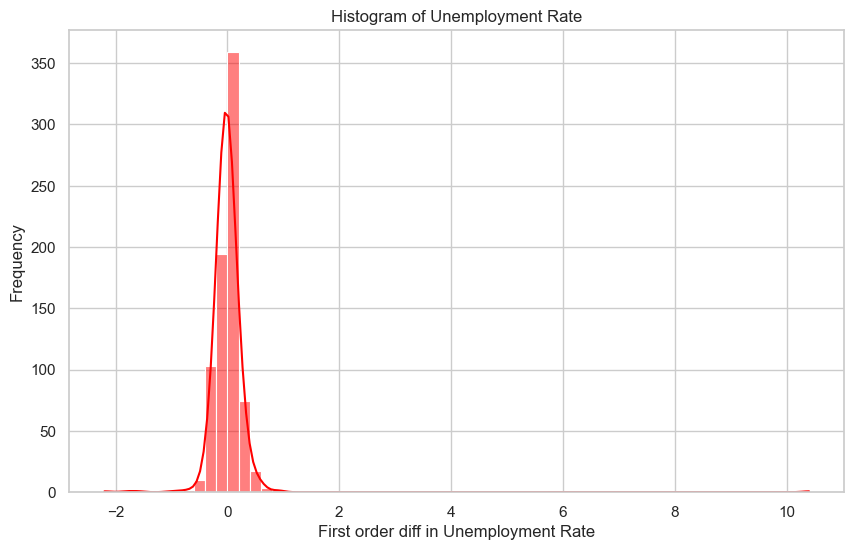

In [82]:
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.histplot(data_diff['unemp rate diff'], kde=True, color='red', binwidth=0.2)  # KDE plots a curve of the distribution's density

# Add titles and labels
plt.title('Histogram of Unemployment Rate')
plt.xlabel('First order diff in Unemployment Rate')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### time series decomposition

In [102]:
data_decomp = data.copy()

In [ ]:
data_decomp.set_index('observation_date', inplace=True)

In [104]:
data_decomp.head()

,UnemploymentRate,GDP,CommLoans,CPIGrowthRate,FedFunds,MoneySupply,ProducerPriceIndex,RELoans,year,month,quarter
observation_date,,,,,,,,,,,
1960-01-01,5.2,15.572097,39.5918,-0.340136,3.99,301.5,31.6,27.6453,1960,1,Q1
1960-02-01,4.8,6.220612,39.3687,0.341297,3.97,298.5,31.6,27.5965,1960,2,Q1
1960-03-01,5.4,-4.063160,40.1776,0.000000,3.84,298.2,31.8,27.6361,1960,3,Q1
1960-04-01,5.2,-4.134117,40.6229,0.340136,3.92,300.3,31.8,27.6951,1960,4,Q2
1960-05-01,5.1,-3.431832,40.8703,0.000000,3.85,298.9,31.7,27.7338,1960,5,Q2


In [106]:
# Check the range and frequency of dates
print(data_decomp.index.min(), data_decomp.index.max())
print(data_decomp.index.freq)

1960-01-01 00:00:00 2024-03-01 00:00:00
None


In [107]:
# Infer the frequency if possible
df.index.freq = df.index.inferred_freq

In [108]:
df.index.freq

<MonthBegin>

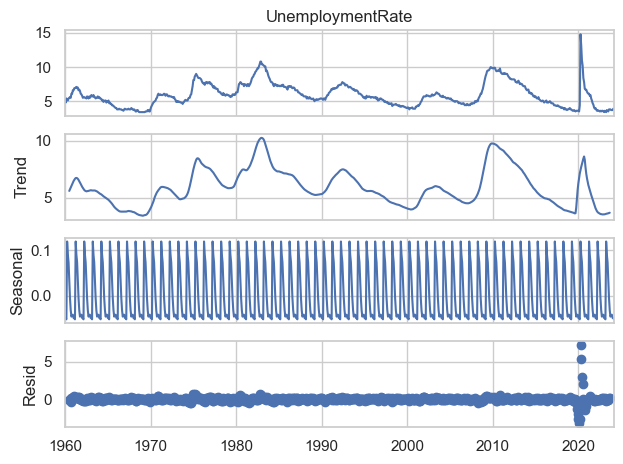

In [109]:
# Decompose the time series
result = seasonal_decompose(data_decomp['UnemploymentRate'], model='additive')  # or model='multiplicative'

# Plotting the components
result.plot()
plt.show()

This time series does not have a trend, but it does have a strong seasonality to it. The residuals are dispersed around the mean of zero. It indicates that the decomposition method has effectively captured the main components of the time series (trend and seasonality), leaving behind residuals that reflect random fluctuations, which do not exhibit systematic patterns or trends.

/Users/susanoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


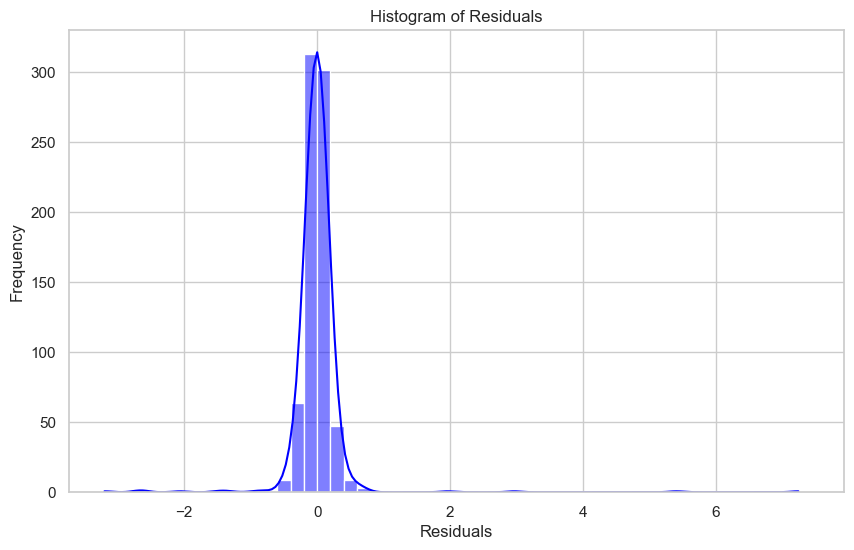

In [115]:
sns.set(style="whitegrid")

# Accessing the residuals from the decomposition result
residuals = result.resid.dropna()  # Drop NA values which may exist at the start or end

# Create the histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', binwidth=0.2)  # KDE (Kernel Density Estimate) adds a density curve
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Show the plot
plt.show()

histogram of residuals which shows that the residuals are normally distributed across the mean zero. It suggests that the errors the model makes are due to random fluctuations that are symmetrically distributed about the mean error

### autocorreln and partial auto

<Figure size 1400x700 with 0 Axes>

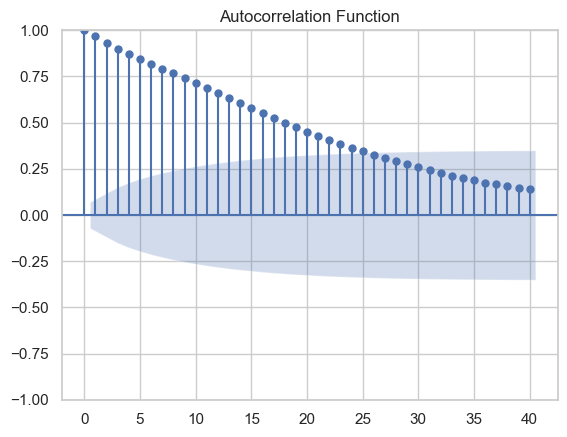

<Figure size 1400x700 with 0 Axes>

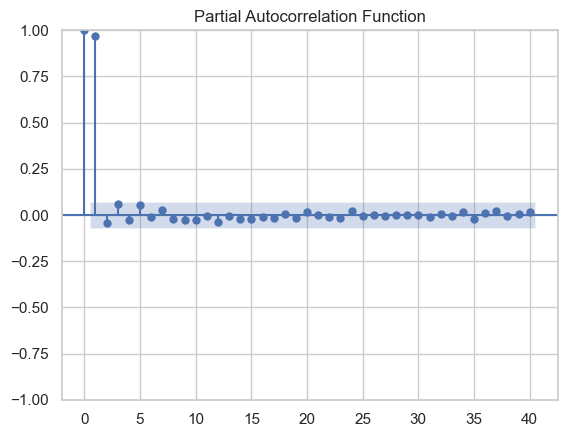

In [117]:
# Plotting the ACF
plt.figure(figsize=(14, 7))
plot_acf(data_decomp['UnemploymentRate'], lags=40, alpha=0.05)  # 'lags' defines the number of lags; 'alpha' is for confidence intervals
plt.title('Autocorrelation Function')

# Plotting the PACF
plt.figure(figsize=(14, 7))
plot_pacf(data_decomp['UnemploymentRate'], lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function')

plt.show()

ACF chart shows that unemployment rate autocorrelation can be seen until 24 lags (24 months). But there are intermediate lags. Therefore, autocorrelation is not the correct measure of mutual correlation between xt and xt+h or xt-h.
PACF chart shows temporal dependence of unemployment rate at a time t with that of t-1 or lag=1 with some weak dependency shown between lags 2 to 5.

### Test for stationarity

In [120]:
data_decomp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 771 entries, 1960-01-01 to 2024-03-01
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UnemploymentRate    771 non-null    float64
 1   GDP                 771 non-null    float64
 2   CommLoans           771 non-null    float64
 3   CPIGrowthRate       771 non-null    float64
 4   FedFunds            771 non-null    float64
 5   MoneySupply         771 non-null    float64
 6   ProducerPriceIndex  771 non-null    float64
 7   RELoans             771 non-null    float64
 8   year                771 non-null    int64  
 9   month               771 non-null    int64  
 10  quarter             771 non-null    object 
dtypes: float64(8), int64(2), object(1)
memory usage: 88.4+ KB


In [121]:
data_stat = data_decomp.copy()

In [122]:
# List of numeric features for ADF test
numeric_features = [
    "UnemploymentRate", "GDP", "CommLoans", "CPIGrowthRate",
    "FedFunds", "MoneySupply", "ProducerPriceIndex", "RELoans"
]

# Function to perform ADF test and return p-value
def perform_adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # p-value

# Applying ADF test and collecting p-values
adf_results = {feature: perform_adf_test(data_stat[feature]) for feature in numeric_features}

# Convert results to DataFrame
adf_p_values = pd.DataFrame(list(adf_results.items()), columns=['Feature', 'P-Value'])

In [128]:
adf_p_values

,Feature,P-Value
0,UnemploymentRate,1.313270e-02
1,GDP,5.022420e-18
2,CommLoans,9.989013e-01
3,CPIGrowthRate,2.041574e-02
4,FedFunds,4.084008e-02
5,MoneySupply,1.000000e+00
6,ProducerPriceIndex,9.892034e-01
7,RELoans,9.986347e-01


Features like GDP, UnemploymentRate, CPIGrowthRate, and FedFunds have relatively low p-values, suggesting that these series are likely to be stationary.
On the other hand, features like CommLoans, MoneySupply, ProducerPriceIndex, and RELoans have very high p-values close to 1, indicating that these series are non-stationary without differencing.

In [129]:
# Function to difference the series and perform ADF test
def difference_and_adf(series):
    differenced_series = series.diff().dropna()  # first difference
    result = adfuller(differenced_series, autolag='AIC')
    return result[1]  # p-value

# Applying first differencing and ADF test
diff_adf_results = {feature: difference_and_adf(data_stat[feature]) for feature in numeric_features}

# Convert results to DataFrame
diff_adf_p_values = pd.DataFrame(list(diff_adf_results.items()), columns=['Feature', 'P-Value after Differencing'])
diff_adf_p_values

,Feature,P-Value after Differencing
0,UnemploymentRate,6.033812e-28
1,GDP,3.568759e-22
2,CommLoans,2.534872e-09
3,CPIGrowthRate,4.670739e-30
4,FedFunds,2.089242e-07
5,MoneySupply,2.022994e-04
6,ProducerPriceIndex,4.108961e-08
7,RELoans,5.491800e-04


All features now have significantly lower p-values, indicating that they have become stationary after the first difference

### Multivariate Data Analysis

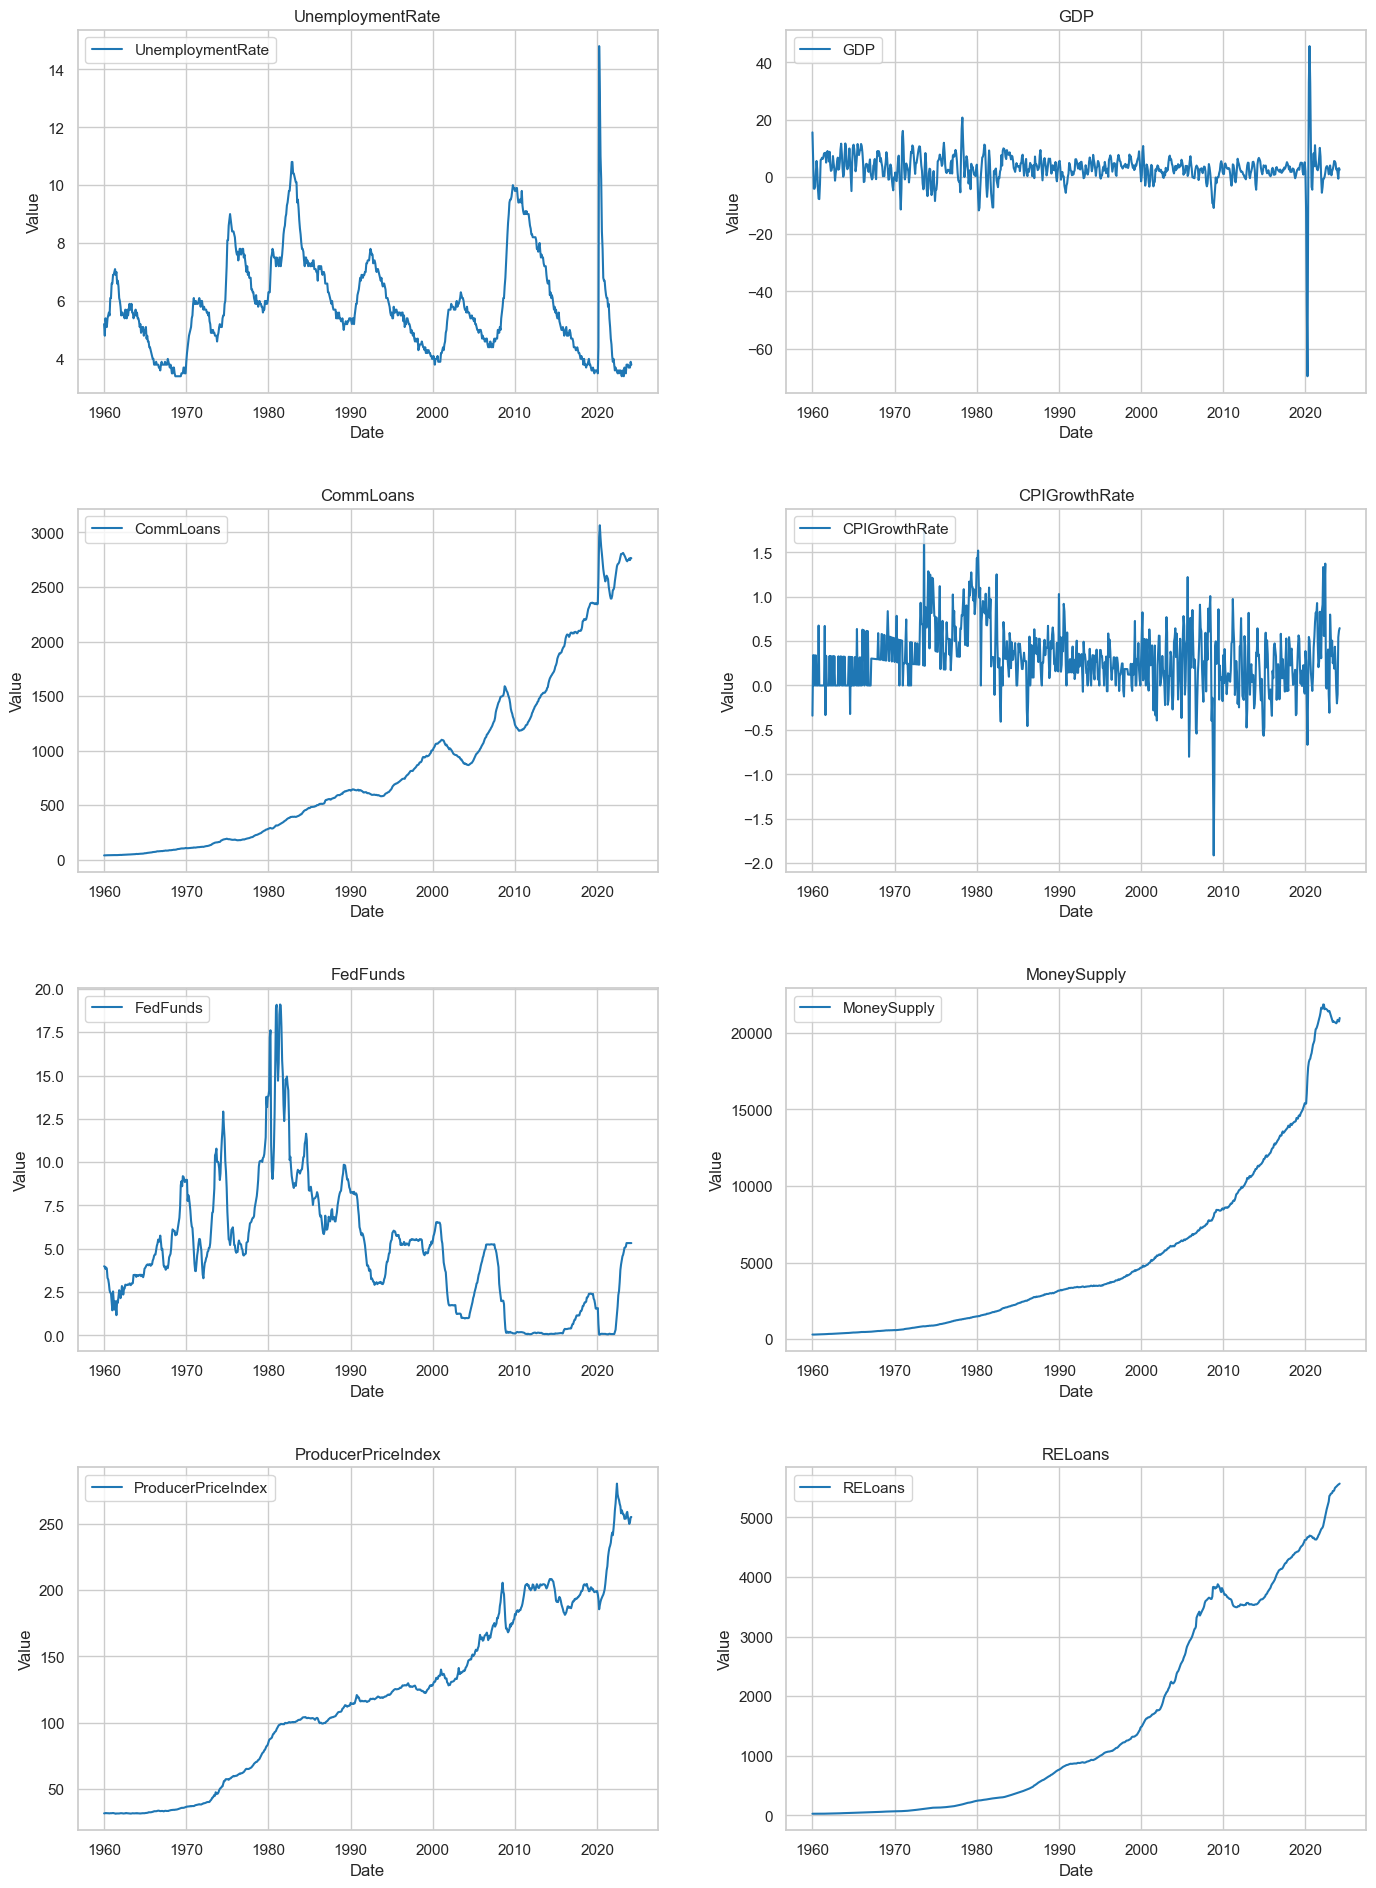

In [134]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=5.0)

# Plot each feature on the appropriate subplot
for i, feature in enumerate(numeric_features):
    row, col = divmod(i, 2)
    axes[row, col].plot(data_stat.index, data_stat[feature], label=feature, color='tab:blue')
    axes[row, col].set_title(feature)
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Value')
    axes[row, col].legend(loc='upper left')

plt.show()


The fed funds rate which is the interest rate that banks charge each other for overnight borrowings was near zero during the financial crisis of 2008 & during covid crisis ,and following that for few years. Producer Price Index (Supplier price inflation), Money Supply (Amount of liquidity provided by Treasury) and Commercial Loan Activities (Commercial & Industrial loans, and CRE loans), are not stationary as determined by ADF tests. These four indicators were differenced to make them stationary.

# Choosing models

## VAR model

### univariate analysis

In [136]:
data_var = data_decomp.copy()

In [152]:
unemployment_rate = data_var['UnemploymentRate']

unemployment_rate_diff = unemployment_rate.diff().dropna()

data_until_2018 = unemployment_rate['1997-01-01':'2015-01-01']
# Step 2: Select AR order (if needed, here it's provided as 5)
from statsmodels.tsa.ar_model import ar_select_order
selected_order = ar_select_order(data_until_2018, maxlag=24, ic='aic', seasonal=False)
print('Selected AR order:', selected_order.ar_lags)

Selected AR order: [1, 2, 3, 4, 5, 6]


/Users/susanoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/susanoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [137]:
data_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 771 entries, 1960-01-01 to 2024-03-01
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UnemploymentRate    771 non-null    float64
 1   GDP                 771 non-null    float64
 2   CommLoans           771 non-null    float64
 3   CPIGrowthRate       771 non-null    float64
 4   FedFunds            771 non-null    float64
 5   MoneySupply         771 non-null    float64
 6   ProducerPriceIndex  771 non-null    float64
 7   RELoans             771 non-null    float64
 8   year                771 non-null    int64  
 9   month               771 non-null    int64  
 10  quarter             771 non-null    object 
dtypes: float64(8), int64(2), object(1)
memory usage: 88.4+ KB


In [154]:
unemployment_rate['1997-01-01':'2015-01-01']

observation_date
1997-01-01    5.3
1997-02-01    5.2
1997-03-01    5.2
1997-04-01    5.1
1997-05-01    4.9
             ... 
2014-09-01    5.9
2014-10-01    5.7
2014-11-01    5.8
2014-12-01    5.6
2015-01-01    5.7
Name: UnemploymentRate, Length: 217, dtype: float64

In [153]:
# We use ARIMA model with d=0 (no differencing) and ma_order=0 (no MA component)
model = sm.tsa.ARIMA(data_until_2018, order=(5, 0, 0))
results = model.fit()


# Step 5: Print the model summary
print(results.summary())

/Users/susanoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/susanoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/susanoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       UnemploymentRate   No. Observations:                  217
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 106.175
Date:                Sun, 25 Aug 2024   AIC                           -198.350
Time:                        02:40:19   BIC                           -174.690
Sample:                    01-01-1997   HQIC                          -188.792
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9398      1.105      5.374      0.000       3.774       8.106
ar.L1          1.0565      0.061     17.278      0.000       0.937       1.176
ar.L2          0.1810      0.094      1.921      0.0